# Data Visualization Notebook

## Objectives
* **Answer Business Requirement 1:** The client aims to gain a deeper understanding of the visual differences between healthy and infected cherry leaves. This understanding will help assess the feasibility of manual classification, inform the development of automated detection methods, and potentially guide treatment strategies. To address this, we will generate visualizations comparing various aspects of healthy and infected leaves.

## Inputs
* data/cherry-leaves/train
* data/cherry-leaves/test
* data/cherry-leaves/validation

## Outputs
* **Mean and Variability Plots:**  Plots showing the average and standard deviation images for both healthy and powdery mildew leaves, allowing us to visualize typical leaf appearance and variations within each class.
* **Difference Plot:** A plot highlighting the areas of greatest difference between the average healthy and infected leaves, potentially revealing key visual indicators of the disease.
* **Image Montages:**  Montages of randomly selected images from each class, showcasing the diversity within each category.
* **Code for Streamlit Dashboard:**  Python code to generate interactive image montages on a Streamlit dashboard, enabling users to explore the dataset visually.


## Additional Comments | Insights | Conclusions
The Data Visualization Notebook provides an exploratory analysis of the cherry leaf dataset to understand the key characteristics and patterns before model training. The visualizations aim to support the business requirements by distinguishing healthy and infected leaves and preparing the dataset for machine learning.

In [3]:
# 1. Import Libraries
import os
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow import keras
from tensorflow.keras.utils import image_dataset_from_directory
from tensorflow.keras.preprocessing import image
import itertools
import random

In [5]:
# 2. Set the data directory
root_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))

# 3. Set Input and Output Directories
data_dir = os.path.join(root_dir, 'data', 'cherry-leaves')
train_path = os.path.join(data_dir, 'train')
test_path = os.path.join(data_dir, 'test')
val_path = os.path.join(data_dir, 'validation')

output_dir = os.path.join(root_dir, 'outputs', 'v1')
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

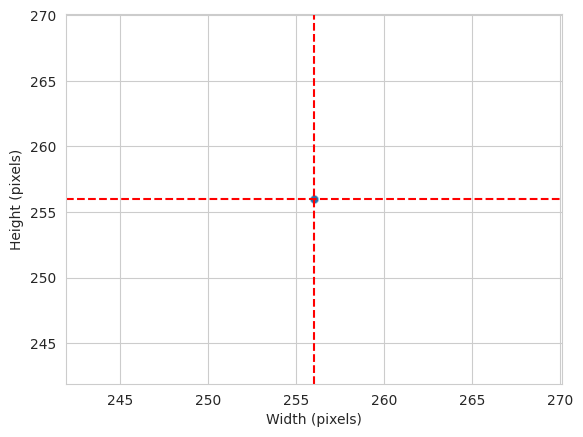

Width average: 256 
Height average: 256


In [6]:
# 4. Analyze image sizes (average width and height)

dim1, dim2 = [], []
for label in os.listdir(train_path):
    for image_filename in os.listdir(os.path.join(train_path, label)):
        img_path = os.path.join(train_path, label, image_filename)
        img = plt.imread(img_path)
        d1, d2, colors = img.shape
        dim1.append(d1)
        dim2.append(d2)

sns.set_style("whitegrid")
fig, axes = plt.subplots()
sns.scatterplot(x=dim2, y=dim1, alpha=0.2)
axes.set_xlabel("Width (pixels)")
axes.set_ylabel("Height (pixels)")
dim1_mean = int(np.array(dim1).mean())
dim2_mean = int(np.array(dim2).mean())
axes.axvline(x=dim1_mean, color='r', linestyle='--')
axes.axhline(y=dim2_mean, color='r', linestyle='--')
plt.show()
print(f"Width average: {dim2_mean} \nHeight average: {dim1_mean}")

# Adjust image shape for smaller model size 

In [8]:
image_shape = (100, 100, 3)  # Reduced shape (100x100)

In [9]:
# 5. Load images into a numpy array
def load_image_as_array(data_dir, new_size, n_images_per_label=20):
    X = []  
    y = [] 
    for label in os.listdir(data_dir):
        counter = 0
        for image_filename in os.listdir(os.path.join(data_dir, label)):
            if counter < n_images_per_label:
                img_path = os.path.join(data_dir, label, image_filename)
                img = image.load_img(img_path, target_size=new_size)
                img_array = image.img_to_array(img)
                img_resized = img_array / 255.0 if img_array.max() > 1 else img_array
                X.append(img_resized)  
                y.append(label)        
                counter += 1

    # Convert lists to NumPy arrays after the loop
    X = np.array(X, dtype='float32')
    y = np.array(y, dtype='object')

    return X, y



X, y = load_image_as_array(train_path, image_shape, n_images_per_label=30)
print(X.shape, y.shape)

(60, 100, 100, 3) (60,)


In [10]:
# 6. Visualization of mean and variability per label

def plot_mean_variability_per_labels(X, y, figsize=(12, 5), save_image=False):
    y = y.reshape(-1, 1, 1) 
    for label_to_display in np.unique(y):
        sns.set_style("white")
        boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
        arr = X[boolean_mask]
        avg_img = np.mean(arr, axis=0)
        std_img = np.std(arr, axis=0)
        print(f"==== Label {label_to_display} ====")
        print(f"Image Shape: {avg_img.shape}")
        fig, axes = plt.subplots(nrows=1, ncols=2, figsize=figsize)
        axes[0].set_title(f"Average Image for label {label_to_display}")
        axes[0].imshow(avg_img)
        axes[1].set_title(f"Variability image for label {label_to_display}")
        axes[1].imshow(std_img)
        if save_image:
            plt.savefig(os.path.join(output_dir, f"avg_var_{label_to_display}.png"), bbox_inches='tight', dpi=150) # Save in output dir
        else:
            plt.tight_layout()
            plt.show()
            print("\n")

In [11]:
# 7. Difference Visualization

def subset_image_label(X, y, label_to_display):
    y = y.reshape(-1, 1, 1)
    boolean_mask = np.any(y == label_to_display, axis=1).reshape(-1)
    df = X[boolean_mask]
    return df


def diff_bet_avg_image_labels_data_as_array(X, y, label_1, label_2, figsize=(20, 5), save_image=False):
    sns.set_style("white")
    if (label_1 not in np.unique(y)) or (label_2 not in np.unique(y)):
        print(f"Either label {label_1} or label {label_2}, are not in {np.unique(y)}")
        return
    images_label = subset_image_label(X, y, label_1)
    label1_avg = np.mean(images_label, axis=0)
    images_label = subset_image_label(X, y, label_2)
    label2_avg = np.mean(images_label, axis=0)
    difference_mean = label1_avg - label2_avg
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=figsize)
    axes[0].imshow(label1_avg)
    axes[0].set_title(f'Average {label_1}')
    axes[1].imshow(label2_avg)
    axes[1].set_title(f'Average {label_2}')
    axes[2].imshow(difference_mean)
    axes[2].set_title(f'Difference image: Avg {label_1} & {label_2}')
    if save_image:
         plt.savefig(os.path.join(output_dir, "avg_diff.png"), bbox_inches='tight', dpi=150)  # Save in output dir
    else:
        plt.tight_layout()
        plt.show()

==== Label healthy ====
Image Shape: (100, 100, 3)
==== Label powdery_mildew ====
Image Shape: (100, 100, 3)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


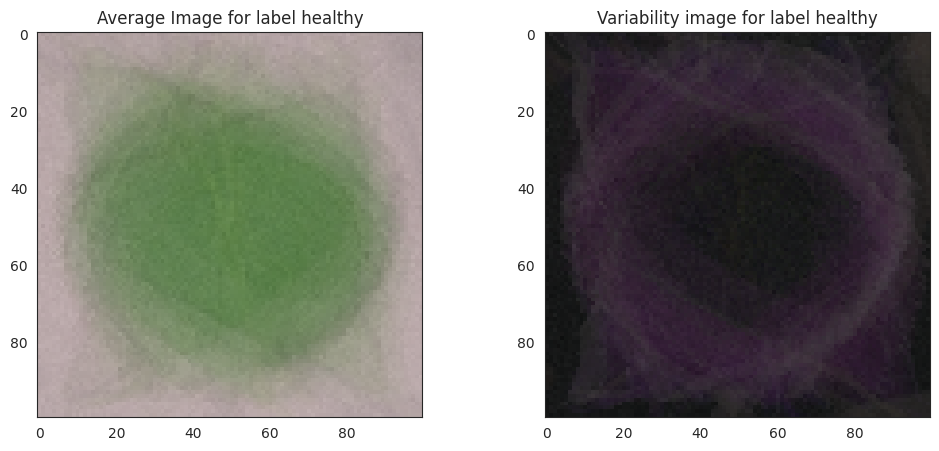

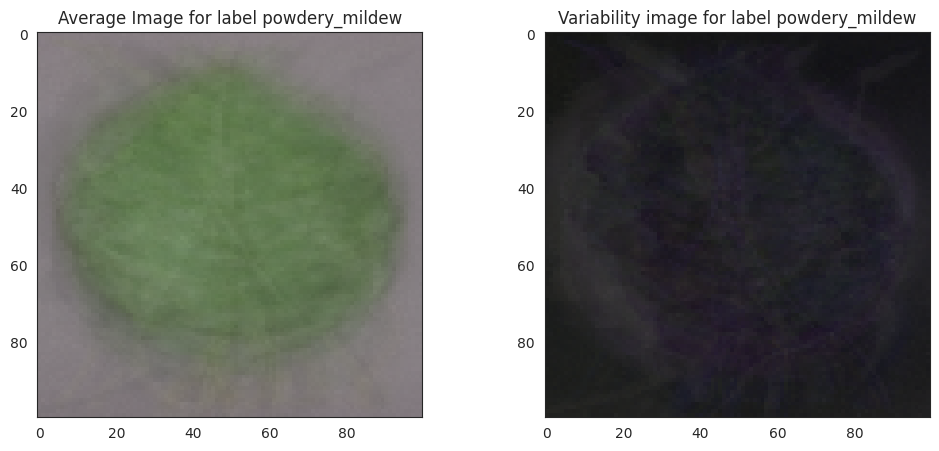

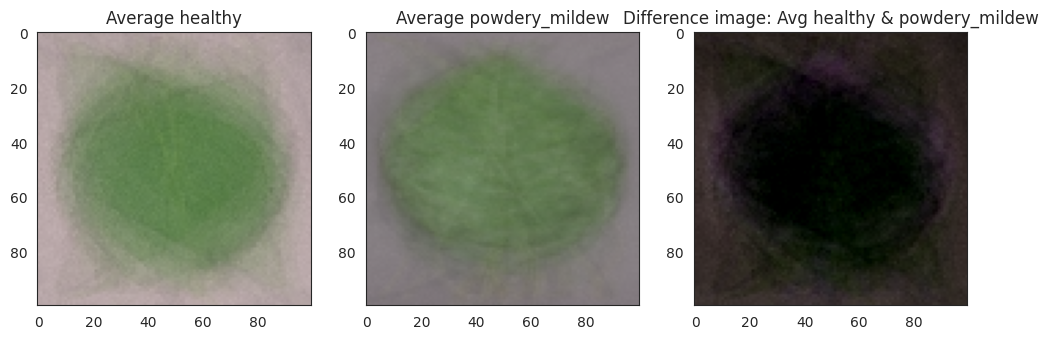

In [12]:
# Call the visualization functions

plot_mean_variability_per_labels(X=X, y=y, figsize=(12, 5), save_image=True)
diff_bet_avg_image_labels_data_as_array(X=X, y=y, label_1='healthy', label_2='powdery_mildew', figsize=(12, 10), save_image=True)


Creating montage for label: powdery_mildew


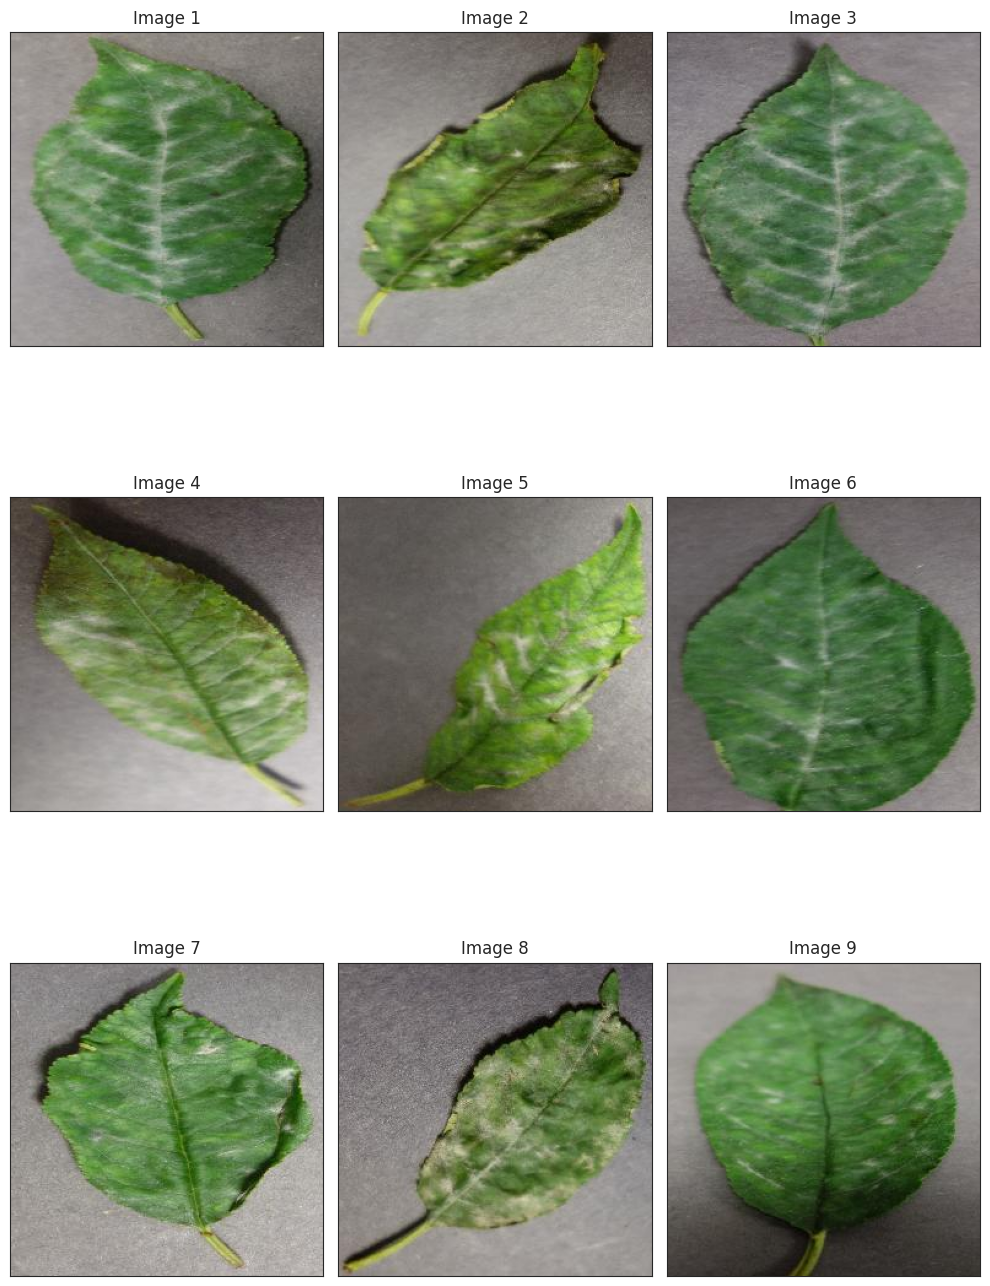



Creating montage for label: healthy


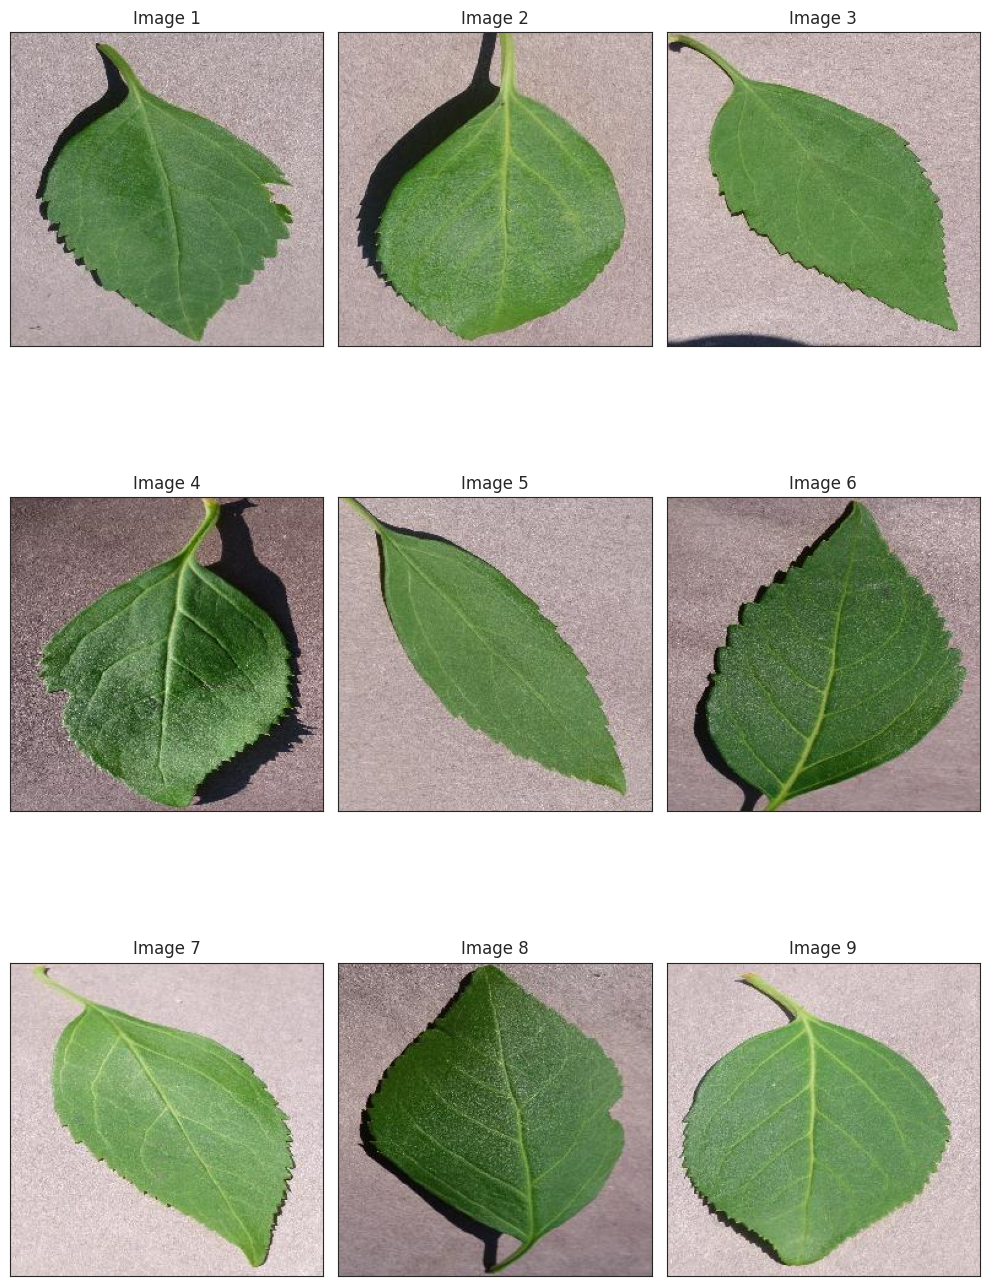

In [13]:
# 7. Creating and displaying image montages

import os
import random
import itertools
import matplotlib.pyplot as plt
import numpy as np

def image_montage(dir_path, label_to_display, nrows, ncols, figsize=(15, 10)):
    labels = os.listdir(dir_path)

    if label_to_display in labels:
        images_list = os.listdir(os.path.join(dir_path, label_to_display))
        num_images = len(images_list)
        if nrows * ncols > num_images:
            print(
                f"Decrease nrows or ncols to create your montage. \n"
                f"There are {num_images} images in your subset. \n"
                f"You requested a montage with {nrows * ncols} spaces"
            )
            return

        img_idx = random.sample(range(num_images), min(nrows * ncols, num_images))

        fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=figsize)

        for i, (row, col) in enumerate(itertools.product(range(nrows), range(ncols))):
            if i < len(img_idx):
                img_path = os.path.join(dir_path, label_to_display, images_list[img_idx[i]])
                img = plt.imread(img_path)

                # Correctly handle single subplot and multiple subplots cases
                if isinstance(axes, np.ndarray):
                    ax = axes[row, col]
                else:  # Single subplot
                    ax = axes

                ax.imshow(img)
                ax.set_title(f"Image {i+1}")
                ax.set_xticks([])
                ax.set_yticks([])
            elif isinstance(axes, np.ndarray):
                axes[row, col].axis('off')
            else:
                axes.axis('off')


        plt.tight_layout()
        plt.show()
    else:
        print("The label you selected doesn't exist.")
        print(f"The existing options are: {labels}")


# Example usage:
if 'train_path' in locals():
    labels = os.listdir(train_path)
    for label in labels:
        print(f"Creating montage for label: {label}")
        image_montage(train_path, label, nrows=3, ncols=3, figsize=(10, 15))
        print("\n")
else:
    print("train_path is not defined. Please set it to the path of your training data.")

## Further Comments

The visualizations reveal that the visual differences between healthy and infected leaves are quite subtle. The changes primarily appear to be in texture and perhaps slight variations in color intensity, making it challenging for human experts to consistently classify leaves based on visual inspection alone.

Analysis of the dataset shows a balanced distribution of classes, with approximately 50% healthy leaves and 50% infected leaves (exact numbers can be provided here). This balance is crucial for preventing bias in the ML model and ensuring accurate predictions for both classes.

## Conclusion

This visualization step confirms the need for machine learning to effectively classify cherry leaves based on their health status. The subtle visual cues associated with powdery mildew infection are difficult to discern with the naked eye, highlighting the potential of CNNs to extract non-obvious patterns and achieve accurate classification.

Given that color contrast appears to be a weak indicator of infection, we may explore using grayscale images or focus on extracting texture-based features during the feature engineering stage. This could potentially simplify the model and improve its efficiency without sacrificing performance.

The balanced nature of the dataset and the insights gained from the visualizations provide confidence in the potential of machine learning to address this challenge effectively. The next step is to proceed with feature engineering and model training, where we will leverage these insights to develop an accurate and reliable classification model.